## Análisis de datos - Clase 7

### Taller práctico - análisis completo de un dataset - parte 2

In [757]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, QuantileTransformer, OrdinalEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from pandas.api.types import CategoricalDtype

---
### Preparación para entrenamiento de un modelo de ML
---

#### Suponemos que queremos predecir quién va a ganar las próximas carreras y plantearemos un problema de clasificación binaria usando la variable "Winner" como target.

#### Importo el dataset

In [758]:
# Leer el JSON
with open("../datasets/carreras_24_1_dtypes.json", "r") as f:
    info = json.load(f)

dtypes_str = info["dtypes"]
categorical_cols = info["categoricals"]

# Detectar columnas especiales
parse_dates = [col for col, dtype in dtypes_str.items() if "datetime" in dtype]
timedeltas = [col for col, dtype in dtypes_str.items() if "timedelta" in dtype]

# Convertir strings de tipo a los tipos correctos
def convertir_dtype(dtype_str):
    if dtype_str.startswith("int"): return "Int64"
    if dtype_str.startswith("float"): return "float"
    if dtype_str == "object": return "string"
    if dtype_str == "bool": return "boolean"
    return "string"

normal_dtypes = {col: convertir_dtype(dtype) for col, dtype in dtypes_str.items()
                 if col not in parse_dates + timedeltas + categorical_cols}


# Leer CSV
carreras_24 = pd.read_csv("../datasets/carreras_24_1.csv", parse_dates=parse_dates, dtype=normal_dtypes)


# Restaurar timedelta
for col in timedeltas:
    carreras_24[col] = pd.to_timedelta(carreras_24[col])

# Restaurar categoricas
for col in categorical_cols:
    carreras_24[col] = carreras_24[col].astype("category")


carreras_24.head()

,EventName,EventDate,Driver,DriverNumber,Team,PitInTime,PitOutTime,IsPersonalBest,Stint,LapTime,...,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate,PitOutTime2,PitTime,PitTime_seconds,Pit
0,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,False,1.0,101.190,...,"[1, 2]",16.0,False,NaN,False,False,NaT,NaT,NaN,False
1,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,120.191,...,"[2, 6]",15.0,False,NaN,False,False,NaT,NaT,NaN,False
2,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,95.776,...,"[6, 7, 1]",15.0,False,NaN,False,False,NaT,NaT,NaN,False
3,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,True,1.0,90.060,...,[1],15.0,False,NaN,False,True,NaT,NaT,NaN,False
4,Abu Dhabi Grand Prix,2024-12-08,ALB,23,Williams,NaT,NaT,False,1.0,90.369,...,[1],15.0,False,NaN,False,True,NaT,NaT,NaN,False


In [759]:
carreras_24.columns

Index(['EventName', 'EventDate', 'Driver', 'DriverNumber', 'Team', 'PitInTime',
       'PitOutTime', 'IsPersonalBest', 'Stint', 'LapTime', 'LapNumber',
       'LapStartTime', 'LapStartDate', 'Sector1Time', 'Sector2Time',
       'Sector3Time', 'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'AirTemp',
       'TrackTemp', 'Humidity', 'Compound', 'TyreLife', 'FreshTyre',
       'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'PitOutTime2', 'PitTime',
       'PitTime_seconds', 'Pit'],
      dtype='object')

#### Atención! 
#### ¿Puedo usar este dataset como está? 

No, porque hay columnas que yo no tendría al momento de la predicción. Supongamos que quiero predecir si un piloto va a ganar la carrera justo antes de el inicio. En ese caso, la información que tendría disponible sería las velocidades promedio de las prácticas, de la clasificación o datos de un año anterior. Sí podría tener por ejemplo los datos del tiempo de la pista al momento de comenzar la carrera, y esos los podría dejar. También podría saber de antemano la estrategia de cubiertas que va a usar el equipo.

En este caso, vamos a utilizar información de velocidades de la clasificación (qualy). 


In [760]:
datos_qualy = pd.read_csv("../datasets/result_qualy.csv") # Contiene los datos de velocidades promedio para cada piloto en cada carrera durante las pruebas de clasificación.

In [761]:
print(datos_qualy.shape)
datos_qualy.head()

(478, 6)


,EventName,Driver,QualyAvg_LapTime,QualyFastest_LapTime,QualyAvgSpeedI1,QualyAvgSpeedI2
0,Abu Dhabi Grand Prix,ALB,95.88450,83.821,265.666667,281.500000
1,Australian Grand Prix,ALB,91.05150,77.130,259.000000,288.466667
2,Austrian Grand Prix,ALB,81.28400,65.736,294.888889,205.333333
3,Azerbaijan Grand Prix,ALB,117.25225,102.840,173.736842,204.894737
4,Bahrain Grand Prix,ALB,104.64050,90.221,201.666667,238.416667


Por otra parte, para mejorar el dataset podríamos complementarlo con un mini dataset con información de las pistas:

In [762]:
circuitos = pd.read_csv("../datasets/pistas.csv")

In [763]:
print(circuitos.shape)
circuitos.head()

(24, 8)


,GrandPrix,Laps,CircuitLength_km,RaceDistance_km,LapRecord_s,Complexity,RainLikelihood,DRSzones
0,Bahrain Grand Prix,57,5.412,308.238,91.447,3,5,3
1,Saudi Arabian Grand Prix,50,6.174,308.450,90.734,4,10,2
2,Australian Grand Prix,58,5.303,307.574,84.125,3,30,3
3,Japanese Grand Prix,53,5.807,307.471,90.983,4,33,2
4,Chinese Grand Prix,56,5.451,305.066,92.238,3,25,2


1) Procesamos el dataset original de carreras. Recordemos que este tenía todas las vueltas que corrió cada piloto en cada carrera. Queremos quedarnos con una fila por piloto por carrera, que contenga información agregada de las vueltas de cada piloto:

In [764]:
# Armo un dataset consolidado con los resultados de cada carrera para cada piloto

result = carreras_24.groupby(['Driver', 'EventName'], observed=True).agg(
    Event_date=('EventDate','first' ),
    Team=('Team','first'),
    Position_start=('Position', 'first'),
    Position_end=('Position', 'last'),
    Tyre_Compound_start=('Compound', 'first'),
    FreshTyre_start=('FreshTyre', 'first'),
    Avg_TrackTemp=('TrackTemp', 'mean'),
    Avg_AirTemp=('AirTemp', 'mean'),
    Avg_Humidity=('Humidity', 'mean'),

).reset_index()

position_start_order = CategoricalDtype(categories=[i for i in range(20, 0, -1)], ordered=True)
result['Position_start'] = result['Position_start'].astype(position_start_order)

# Agrego el ganador
result['Winner']= np.where(result['Position_end']==1,1,0)
result['Winner'] = result['Winner'].astype('category')
result = result.drop(['Position_end'], axis=1) # Saco esta columna porque la posición final no la tengo al momento de la predicción

result.head()

,Driver,EventName,Event_date,Team,Position_start,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner
0,ALB,Abu Dhabi Grand Prix,2024-12-08,Williams,16,MEDIUM,True,30.682456,26.424561,54.894737,0
1,ALB,Australian Grand Prix,2024-03-24,Williams,14,MEDIUM,True,38.550877,21.201754,43.245614,0
2,ALB,Austrian Grand Prix,2024-06-30,Williams,15,MEDIUM,True,46.418571,29.724286,34.328571,0
3,ALB,Azerbaijan Grand Prix,2024-09-15,Williams,9,HARD,True,43.356863,26.501961,37.019608,0
4,ALB,Bahrain Grand Prix,2024-03-02,Williams,11,SOFT,True,22.828571,18.012500,49.928571,0


In [765]:
result.shape

(478, 11)

Ahora combinamos todos los datasets: el de carreras consolidado ("result"), el de velocidades promedio en la qualy ("datos_qualy") y el de información de pistas ("circuitos"). Al dataset final lo volvemos a llamar "result":

In [766]:
# Agregamos los datos de la qualy
result = result.merge(
    datos_qualy,
    how='left',
    on=['EventName', 'Driver']
)

# Agregamos los datos de las pistas
result = result.merge(
    circuitos,
    how='left',
    left_on='EventName',
    right_on='GrandPrix'
)
result = result.drop(['EventName', 'GrandPrix'], axis=1)

# Ajusto los dtypes 
result['Laps'] = result['Laps'].astype('Int64') 
result['CircuitLength_km'] = result['CircuitLength_km'].astype(float)
result['RaceDistance_km'] = result['RaceDistance_km'].astype(float)
result['LapRecord_s'] = result['LapRecord_s'].astype(float)
result['RainLikelihood'] = (result['RainLikelihood']/100).astype(float)
result['DRSzones'] = result['DRSzones'].astype('Int64')

complexity_order = CategoricalDtype(categories=[1, 2, 3, 4, 5], ordered=True)
result['Complexity'] = result['Complexity'].astype(complexity_order)

result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Driver                478 non-null    object        
 1   Event_date            478 non-null    datetime64[ns]
 2   Team                  478 non-null    category      
 3   Position_start        465 non-null    category      
 4   Tyre_Compound_start   478 non-null    category      
 5   FreshTyre_start       478 non-null    category      
 6   Avg_TrackTemp         478 non-null    float64       
 7   Avg_AirTemp           478 non-null    float64       
 8   Avg_Humidity          478 non-null    float64       
 9   Winner                478 non-null    category      
 10  QualyAvg_LapTime      477 non-null    float64       
 11  QualyFastest_LapTime  477 non-null    float64       
 12  QualyAvgSpeedI1       477 non-null    float64       
 13  QualyAvgSpeedI2     

In [767]:
result.head()

,Driver,Event_date,Team,Position_start,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner,...,QualyFastest_LapTime,QualyAvgSpeedI1,QualyAvgSpeedI2,Laps,CircuitLength_km,RaceDistance_km,LapRecord_s,Complexity,RainLikelihood,DRSzones
0,ALB,2024-12-08,Williams,16,MEDIUM,True,30.682456,26.424561,54.894737,0,...,83.821,265.666667,281.500000,55,5.554,305.355,99.283,2,0.05,2
1,ALB,2024-03-24,Williams,14,MEDIUM,True,38.550877,21.201754,43.245614,0,...,77.130,259.000000,288.466667,58,5.303,307.574,84.125,3,0.30,3
2,ALB,2024-06-30,Williams,15,MEDIUM,True,46.418571,29.724286,34.328571,0,...,65.736,294.888889,205.333333,71,4.318,306.452,66.957,2,0.45,2
3,ALB,2024-09-15,Williams,9,HARD,True,43.356863,26.501961,37.019608,0,...,102.840,173.736842,204.894737,51,6.003,306.049,103.009,4,0.20,2
4,ALB,2024-03-02,Williams,11,SOFT,True,22.828571,18.012500,49.928571,0,...,90.221,201.666667,238.416667,57,5.412,308.238,91.447,3,0.05,3


Por último voy a ordenar el dataset por fecha del evento, porque después me va a servir para hacer el split del dataset correctamente:

In [768]:
result = result.sort_values('Event_date').reset_index(drop=True)

result.head()

,Driver,Event_date,Team,Position_start,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Winner,...,QualyFastest_LapTime,QualyAvgSpeedI1,QualyAvgSpeedI2,Laps,CircuitLength_km,RaceDistance_km,LapRecord_s,Complexity,RainLikelihood,DRSzones
0,OCO,2024-03-02,Alpine,16,SOFT,True,22.826786,18.007143,49.946429,0,...,90.793,195.444444,225.444444,57,5.412,308.238,91.447,3,0.05,3
1,BOT,2024-03-02,Kick Sauber,18,SOFT,True,22.823214,18.007143,49.964286,0,...,90.756,208.833333,247.166667,57,5.412,308.238,91.447,3,0.05,3
2,PIA,2024-03-02,McLaren,8,SOFT,False,22.822807,18.007018,49.912281,0,...,89.683,220.888889,238.222222,57,5.412,308.238,91.447,3,0.05,3
3,ALO,2024-03-02,Aston Martin,6,SOFT,False,22.824561,18.007018,49.912281,0,...,89.542,216.857143,221.071429,57,5.412,308.238,91.447,3,0.05,3
4,ZHO,2024-03-02,Kick Sauber,13,SOFT,True,22.830357,18.012500,49.910714,0,...,90.757,225.833333,246.500000,57,5.412,308.238,91.447,3,0.05,3


---
### 1. Split del dataset
---

#### El split del dataset no lo debería hacer en forma aleatoria, porque tengo una fila por cada piloto para cada evento. Si hago un split random, puede que me queden filas para un mismo evento en test y train, y estaría haciendo data leakage. 
#### Para evitar esto, puedo hacer el split a partir de un cierto evento (por fecha). Un 80-20 se conseguiría tomando X_train = primeros 19 eventos del 2024 y X_test = últimos 5 eventos.

In [769]:
# Ordeno las fechas para hacer el split
np.sort(result['Event_date'].unique()) # Hago esto porque tengo una fila por cada piloto para el mismo evento, me quedo con las fechas únicas.

array(['2024-03-02T00:00:00.000000000', '2024-03-09T00:00:00.000000000',
       '2024-03-24T00:00:00.000000000', '2024-04-07T00:00:00.000000000',
       '2024-04-21T00:00:00.000000000', '2024-05-05T00:00:00.000000000',
       '2024-05-19T00:00:00.000000000', '2024-05-26T00:00:00.000000000',
       '2024-06-09T00:00:00.000000000', '2024-06-23T00:00:00.000000000',
       '2024-06-30T00:00:00.000000000', '2024-07-07T00:00:00.000000000',
       '2024-07-21T00:00:00.000000000', '2024-07-28T00:00:00.000000000',
       '2024-08-25T00:00:00.000000000', '2024-09-01T00:00:00.000000000',
       '2024-09-15T00:00:00.000000000', '2024-09-22T00:00:00.000000000',
       '2024-10-20T00:00:00.000000000', '2024-10-27T00:00:00.000000000',
       '2024-11-03T00:00:00.000000000', '2024-11-23T00:00:00.000000000',
       '2024-12-01T00:00:00.000000000', '2024-12-08T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [770]:
# Hago un split preliminar
fecha_split = pd.Timestamp('2024-10-27')

data_train = result[result['Event_date'] < fecha_split].copy()
data_test = result[result['Event_date'] >= fecha_split].copy()

# Datos para train
y_train_raw = data_train['Winner'].copy()
X_train_raw = data_train.drop(['Winner'], axis=1)

# Datos para test
y_test_raw = data_test['Winner'].copy()
X_test_raw = data_test.drop(['Winner'], axis=1)

# Verifico el split
print(f"últimas 5 filas de X_train: \n{X_train_raw['Event_date'].tail()}\n")
print(f"primeras 5 filas de X_test: \n{X_test_raw['Event_date'].head()}")

últimas 5 filas de X_train: 
374   2024-10-20
375   2024-10-20
376   2024-10-20
377   2024-10-20
378   2024-10-20
Name: Event_date, dtype: datetime64[ns]

primeras 5 filas de X_test: 
379   2024-10-27
380   2024-10-27
381   2024-10-27
382   2024-10-27
383   2024-10-27
Name: Event_date, dtype: datetime64[ns]


In [771]:
X_train_raw.columns

Index(['Driver', 'Event_date', 'Team', 'Position_start', 'Tyre_Compound_start',
       'FreshTyre_start', 'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity',
       'QualyAvg_LapTime', 'QualyFastest_LapTime', 'QualyAvgSpeedI1',
       'QualyAvgSpeedI2', 'Laps', 'CircuitLength_km', 'RaceDistance_km',
       'LapRecord_s', 'Complexity', 'RainLikelihood', 'DRSzones'],
      dtype='object')

In [772]:
# Saco Event_date porque ya no me sirve (la usé solo para filtrar)
if 'Event_date' in X_train_raw.columns:
    X_train_raw = X_train_raw.drop(['Event_date'], axis=1)
if 'Event_date' in X_test_raw.columns:
    X_test_raw = X_test_raw.drop(['Event_date'], axis=1)

print(f"Dimensiones de X_train_raw:{X_train_raw.shape}")
print(f"Dimensiones de y_train_raw:{y_train_raw.shape}")
print(f"Dimensiones de X_test_raw:{X_test_raw.shape}")
print(f"Dimensiones de y_test_raw:{y_test_raw.shape}")

Dimensiones de X_train_raw:(379, 19)
Dimensiones de y_train_raw:(379,)
Dimensiones de X_test_raw:(99, 19)
Dimensiones de y_test_raw:(99,)


In [773]:
X_train_raw.columns

Index(['Driver', 'Team', 'Position_start', 'Tyre_Compound_start',
       'FreshTyre_start', 'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity',
       'QualyAvg_LapTime', 'QualyFastest_LapTime', 'QualyAvgSpeedI1',
       'QualyAvgSpeedI2', 'Laps', 'CircuitLength_km', 'RaceDistance_km',
       'LapRecord_s', 'Complexity', 'RainLikelihood', 'DRSzones'],
      dtype='object')

Text(0.5, 1.0, 'Avg_AirTemp')

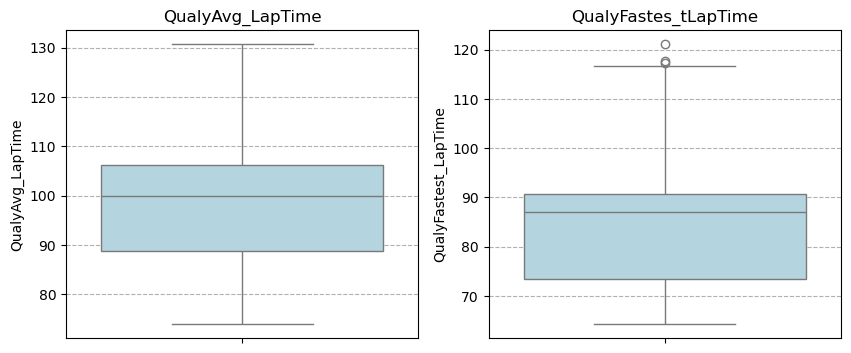

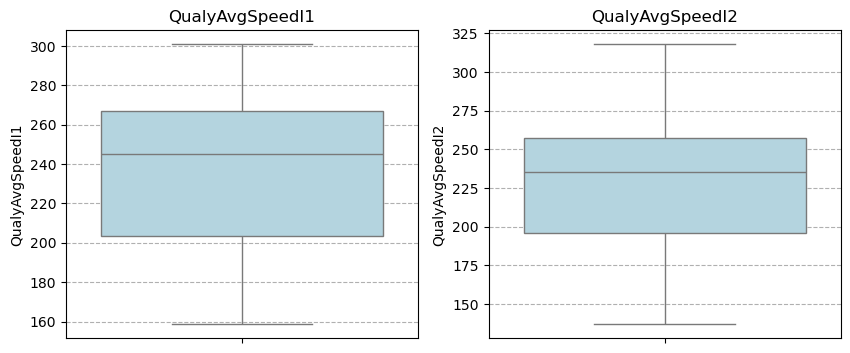

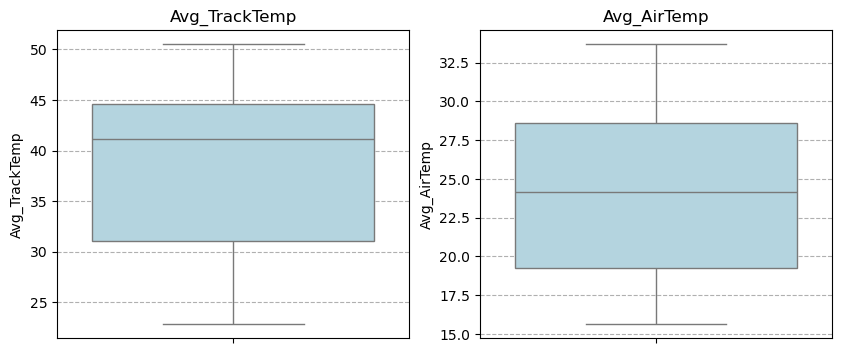

In [774]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='QualyAvg_LapTime', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='QualyFastest_LapTime', color="lightblue", ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('QualyAvg_LapTime', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('QualyFastes_tLapTime', fontsize=12)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='QualyAvgSpeedI1', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='QualyAvgSpeedI2', color="lightblue", ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('QualyAvgSpeedI1', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('QualyAvgSpeedI2', fontsize=12)


ig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(data=X_train_raw, y='Avg_TrackTemp', color="lightblue", ax=ax[0])
sns.boxplot(data=X_train_raw, y='Avg_AirTemp', color="lightblue", ax=ax[1])       
ax[0].grid(axis='y', ls='--')
ax[0].set_title('Avg_TrackTemp', fontsize=12)
ax[1].grid(axis='y', ls='--')
ax[1].set_title('Avg_AirTemp', fontsize=12)

Nota: se observan outliers solo en QualyFastestLapTime.

 ---
 #### Implementación de pipeline para preprocesamiento
 ---


#### Scikit-learn tiene una función muy interesante que arma una pipeline para hacer el procesamiento más fácil y en un solo paso. A continuación vamos a mostrar cómo la utilizaríamos en este caso.

In [775]:
# Creo grupos de variables con las que requieren el mismo tratamiento
numericas = [
    'QualyAvg_LapTime', 'QualyFastest_LapTime', 'QualyAvgSpeedI1', 'QualyAvgSpeedI2',
    'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity', 'Laps',
    'CircuitLength_km', 'RaceDistance_km', 'LapRecord_s', 'RainLikelihood', 
    'DRSzones'
]

ordinales = ['Position_start', 'Complexity']

bajacard = ['FreshTyre_start', 'Tyre_Compound_start']  # Baja cardinalidad
nominales = ['Driver', 'Team']  # Cardinalidad media 

print(f"\nVariables numéricas: {numericas}")
print(f"Ordinales: {ordinales}")
print(f"Variables binarias: {bajacard}")
print(f"Variables nominales (cardinalidad media): {nominales}")



Variables numéricas: ['QualyAvg_LapTime', 'QualyFastest_LapTime', 'QualyAvgSpeedI1', 'QualyAvgSpeedI2', 'Avg_TrackTemp', 'Avg_AirTemp', 'Avg_Humidity', 'Laps', 'CircuitLength_km', 'RaceDistance_km', 'LapRecord_s', 'RainLikelihood', 'DRSzones']
Ordinales: ['Position_start', 'Complexity']
Variables binarias: ['FreshTyre_start', 'Tyre_Compound_start']
Variables nominales (cardinalidad media): ['Driver', 'Team']


In [776]:
X_train_raw.head(100)

,Driver,Team,Position_start,Tyre_Compound_start,FreshTyre_start,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,QualyAvg_LapTime,QualyFastest_LapTime,QualyAvgSpeedI1,QualyAvgSpeedI2,Laps,CircuitLength_km,RaceDistance_km,LapRecord_s,Complexity,RainLikelihood,DRSzones
0,OCO,Alpine,16,SOFT,True,22.826786,18.007143,49.946429,104.579833,90.793,195.444444,225.444444,57,5.412,308.238,91.447,3,0.05,3
1,BOT,Kick Sauber,18,SOFT,True,22.823214,18.007143,49.964286,105.147250,90.756,208.833333,247.166667,57,5.412,308.238,91.447,3,0.05,3
2,PIA,McLaren,8,SOFT,False,22.822807,18.007018,49.912281,101.271091,89.683,220.888889,238.222222,57,5.412,308.238,91.447,3,0.05,3
3,ALO,Aston Martin,6,SOFT,False,22.824561,18.007018,49.912281,107.380778,89.542,216.857143,221.071429,57,5.412,308.238,91.447,3,0.05,3
4,ZHO,Kick Sauber,13,SOFT,True,22.830357,18.012500,49.910714,102.071000,90.757,225.833333,246.500000,57,5.412,308.238,91.447,3,0.05,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,SAR,Williams,20,SOFT,True,29.214286,18.553571,66.571429,106.499333,96.358,268.285714,245.714286,56,5.451,305.066,92.238,3,0.25,2
96,RIC,RB,15,MEDIUM,True,30.027273,18.727273,66.000000,109.995000,94.934,233.250000,229.666667,56,5.451,305.066,92.238,3,0.25,2
97,OCO,Alpine,12,MEDIUM,True,29.228571,18.555357,66.553571,106.535667,95.223,225.066667,237.000000,56,5.451,305.066,92.238,3,0.25,2
98,RUS,Mercedes,6,MEDIUM,True,29.230357,18.551786,66.517857,112.216917,94.433,252.000000,251.350000,56,5.451,305.066,92.238,3,0.25,2


In [777]:
X_train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 378
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Driver                379 non-null    object  
 1   Team                  379 non-null    category
 2   Position_start        372 non-null    category
 3   Tyre_Compound_start   379 non-null    category
 4   FreshTyre_start       379 non-null    category
 5   Avg_TrackTemp         379 non-null    float64 
 6   Avg_AirTemp           379 non-null    float64 
 7   Avg_Humidity          379 non-null    float64 
 8   QualyAvg_LapTime      378 non-null    float64 
 9   QualyFastest_LapTime  378 non-null    float64 
 10  QualyAvgSpeedI1       378 non-null    float64 
 11  QualyAvgSpeedI2       378 non-null    float64 
 12  Laps                  379 non-null    Int64   
 13  CircuitLength_km      379 non-null    float64 
 14  RaceDistance_km       379 non-null    float64 
 15  LapRecord_s

Consideraciones:

Transformaciones a las numéricas:
* SimpleImputer con imputación con la mediana (como ejemplo)
* QuantileTransformer para manejo de outliers tranformándolos a una normal.

Transformaciones categóricas:
* SimpleImputer con imputación por moda para los valores faltantes de las categóricas (como ejemplo)
* OneHotEncoder para codificarlas

Defino pipelines intermedias para transformar grupos de variables:

In [778]:
transformar_numericas = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), # Ejemplo de imputación
    ('outlier_handler', QuantileTransformer(output_distribution='normal')), # Sirve para manejo de outliers, el método del IQR no viene en sckikit-learn pero se puede armar con una función custom.
    ('scaler', StandardScaler())
])

# Esta función fuerza el tipo de datos a string
def convertir_a_string(X):
    return X.astype(str)

transformar_ordinales = Pipeline(steps=[
    ('to_str', FunctionTransformer(convertir_a_string, validate=False)),
    ('imputer', SimpleImputer(strategy='most_frequent')),# Ejemplo de imputación
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('scaler', StandardScaler())
])


transformar_bajacard = Pipeline(steps=[
    ('to_str', FunctionTransformer(convertir_a_string, validate=False)),
    ('imputer', SimpleImputer(strategy='most_frequent')), # Ejemplo de imputación
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))  # drop=first para reducir los features
])

transformar_nominales = Pipeline(steps=[
    # El primer paso a string lo agregué porque me daba un error 
    # de tipo de dato las categóricas y con esto lo fuerzo
    ('to_str', FunctionTransformer(convertir_a_string, validate=False)),
    ('imputer', SimpleImputer(strategy='most_frequent')), # Ejemplo de imputación
    ('target_encoder', TargetEncoder(handle_unknown='value')), # Si se encuentra con una categoría desconocida, codifica con la media global del set de entrenamiento
    ('scaler', StandardScaler()),
])

Crear la función que hace el preprocesamiento (contiene las pipelines intermedias)

In [779]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformar_numericas, numericas),
        ('ord', transformar_ordinales, ordinales),
        ('bcard', transformar_bajacard, bajacard),
        ('nom', transformar_nominales, nominales)
    ],
    remainder='drop' # Esto es best-practice para evitar columnas no transformadas
)

In [780]:
X_train_raw['Tyre_Compound_start'].unique()

['SOFT', 'MEDIUM', 'HARD', 'WET', 'INTERMEDIATE']
Categories (6, object): ['HARD', 'INTERMEDIATE', 'MEDIUM', 'SOFT', 'UNKNOWN', 'WET']

Crear la pipeline final:

In [781]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
pipeline.fit(X_train_raw, y_train_raw) # y_train_raw lo necesita solo para el target encoder

pipeline


/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (379). n_quantiles is set to n_samples.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_handler',
                                                                   QuantileTransformer(output_distribution='normal')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['QualyAvg_LapTime',
                                                   'QualyFastest_LapTime',
                                                   'QualyAvgSpeedI1',
                                                   'QualyAvgSpeedI2',
                                                   'Avg_TrackTemp',
                                                   'Avg_AirTemp',
                                                   'Avg_Humi...
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['FreshTyre_start',
                                                   'Tyre_Compound_start']),
                                                 ('nom',
                                                  Pipeline(steps=[('to_str',
                                                                   FunctionTransformer(func=<function convertir_a_string at 0x16b334860>)),
                                                                  ('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Driver', 'Team'])]))])

In [782]:
X_train_procesado = pipeline.transform(X_train_raw)
X_test_procesado = pipeline.transform(X_test_raw)

/Users/ari/opt/miniconda3/envs/add-env/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [783]:
print(f"\nShape de X_train_procesado: {X_train_procesado.shape}")
print(f"Shape de X_test_procesado: {X_test_procesado.shape}")


Shape de X_train_procesado: (379, 22)
Shape de X_test_procesado: (99, 22)


In [784]:
type(X_train_procesado)

numpy.ndarray

Verificamos qué hizo - hay que reconstruir el DF

In [785]:
# Convertimos el resultado a un DataFrame:

pasos_preprocesador_ajustado = pipeline.named_steps['preprocessor'] # Accedemos a los nombres de los pasos de la pipeline

numericas_salida = numericas # las numéricas transformadas
ordinales_salida = ordinales # las ordinales transformadas
nominales_salida = nominales

# Me paro en la pipeline de transformación de las nominales
pasos_pipeline_binarias = pasos_preprocesador_ajustado.named_transformers_['bcard'] 

# Ahora acceso al one-hot encoder adentro de la pipeline nominal
pasos_onehot_encoder = pasos_pipeline_binarias.named_steps['onehot'] # Me meto adentro de la pipeline nominal

# Ahora me traigo los nuevos nombres de variables creados por el one-hot
binarias_salida = pasos_onehot_encoder.get_feature_names_out(bajacard)

# Armamos los nombres de las variables en orden de acuerdo a la pipeline
transformed_feature_names = (
    list(numericas_salida) +
    list(ordinales_salida) +
    list(binarias_salida) +
    list(nominales_salida) 
)

# Reconstruimos el dataframe procesado
X_train_preproc = pd.DataFrame(X_train_procesado, columns=transformed_feature_names)
X_test_preproc = pd.DataFrame(X_test_procesado, columns=transformed_feature_names)

X_train_preproc.head(10)

,QualyAvg_LapTime,QualyFastest_LapTime,QualyAvgSpeedI1,QualyAvgSpeedI2,Avg_TrackTemp,Avg_AirTemp,Avg_Humidity,Laps,CircuitLength_km,RaceDistance_km,...,DRSzones,Position_start,Complexity,FreshTyre_start_True,Tyre_Compound_start_INTERMEDIATE,Tyre_Compound_start_MEDIUM,Tyre_Compound_start_SOFT,Tyre_Compound_start_WET,Driver,Team
0,0.493279,0.659916,-0.850011,-0.209337,-1.878684,-1.083153,0.037637,-0.035198,0.03479,0.300747,...,0.623488,-0.450306,-0.538768,1.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
1,0.537031,0.628226,-0.574382,0.367666,-2.186187,-1.083153,0.050242,-0.035198,0.03479,0.300747,...,0.623488,-0.111683,-0.538768,1.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
2,0.126220,0.436514,-0.450552,0.075589,-2.287435,-1.126513,-0.031632,-0.035198,0.03479,0.300747,...,0.623488,1.412119,-0.538768,0.0,0.0,0.0,1.0,0.0,0.598585,1.233286
3,0.734094,0.401825,-0.507743,-0.307327,-2.069628,-1.126513,-0.031632,-0.035198,0.03479,0.300747,...,0.623488,1.073496,-0.538768,0.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
4,0.196461,0.636082,-0.374459,0.354137,-1.582496,-0.970208,-0.063151,-0.035198,0.03479,0.300747,...,0.623488,-0.958239,-0.538768,1.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
5,0.340680,0.394953,-0.464689,-0.145292,-1.742840,-1.179136,-0.031632,-0.035198,0.03479,0.300747,...,0.623488,0.734874,-0.538768,0.0,0.0,0.0,1.0,0.0,-0.572552,2.030947
6,0.254725,0.493279,-0.500497,0.037765,-2.644857,-1.126513,0.056548,-0.035198,0.03479,0.300747,...,0.623488,0.057628,-0.538768,1.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
7,0.898097,0.360892,-0.692363,-0.388102,-1.742840,-1.030521,-0.031632,-0.035198,0.03479,0.300747,...,0.623488,0.565562,-0.538768,0.0,0.0,0.0,1.0,0.0,0.598585,0.435624
8,0.287499,0.667954,-0.581958,-0.294094,-1.878684,-1.158984,0.037637,-0.035198,0.03479,0.300747,...,0.623488,-0.280994,-0.538768,1.0,0.0,0.0,1.0,0.0,-0.572552,-0.760868
9,0.145292,0.415634,-0.559338,0.031468,-1.977871,-1.030521,-0.031632,-0.035198,0.03479,0.300747,...,0.623488,1.242807,-0.538768,0.0,0.0,0.0,1.0,0.0,1.184153,1.233286


In [786]:
X_train_preproc.shape

(379, 22)

---
#### 4. Selección de features
---

#### Información mutua

In [787]:
selector_mi = SelectKBest(score_func=mutual_info_classif, k=10)
selector_mi.fit(X_train_preproc, y_train_raw)

# Aplicar el filtro a train
X_train_selected = selector_mi.transform(X_train_preproc)
# Aplicar el filtro a test
X_test_selected = selector_mi.transform(X_test_preproc)

selected_indices = selector_mi.get_support()
selected_features = X_train_preproc.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in zip(selected_features, scores):
    print(f"{feature}: {score:.4f}")

print(f"\nShape del dataset de train después de la selección): {X_train_selected.shape}")
print(f"Shape del dataset de test después de la selección): {X_test_selected.shape}")



Características seleccionadas (Inf. mutua):
DRSzones: 0.0000
Position_start: 0.0966
Complexity: 0.0013
FreshTyre_start_True: 0.0000
Tyre_Compound_start_INTERMEDIATE: 0.0000
Tyre_Compound_start_MEDIUM: 0.0000
Tyre_Compound_start_SOFT: 0.0114
Tyre_Compound_start_WET: 0.0000
Driver: 0.0636
Team: 0.0529

Shape del dataset de train después de la selección): (379, 10)
Shape del dataset de test después de la selección): (99, 10)


---
#### 5. Extracción de features 
---

#### PCA

In [788]:
# Aplicar PCA
pca = PCA(n_components=5)
#components = pca.fit_transform(X_train_preproc) # Hacer PCA sobre el dataset sin filtrar
components = pca.fit_transform(X_train_selected) # Hacer PCA sobre el dataset filtrado por inf. mutua

# Resultado como DataFrame para graficar o analizar
df_components = pd.DataFrame(components, columns=['PC1', 'PC2','PC3', 'PC4', 'PC5'])
df_components['Winner'] = y_train_raw


In [789]:
df_components

,PC1,PC2,PC3,PC4,PC5,Winner
0,-1.106929,-0.951906,-0.065440,0.014876,-0.714066,0
1,-1.040167,-0.876963,0.251990,0.034617,-0.720108,0
2,1.433820,-0.719101,1.386712,0.069097,-1.144538,0
3,-0.827549,-0.639505,1.385643,0.093281,-0.924883,0
4,-1.207071,-1.064319,-0.541584,-0.014734,-0.705004,0
...,...,...,...,...,...,...
374,-0.909398,-0.294288,0.154188,-0.294736,0.592954,0
375,0.680621,-0.463868,0.016108,-0.374253,-0.347155,0
376,0.049700,-0.680514,-0.949413,-0.429639,-0.320131,0
377,-1.150904,-0.556232,-0.956673,-0.363734,0.615230,0


#### Graficamos dos componentes

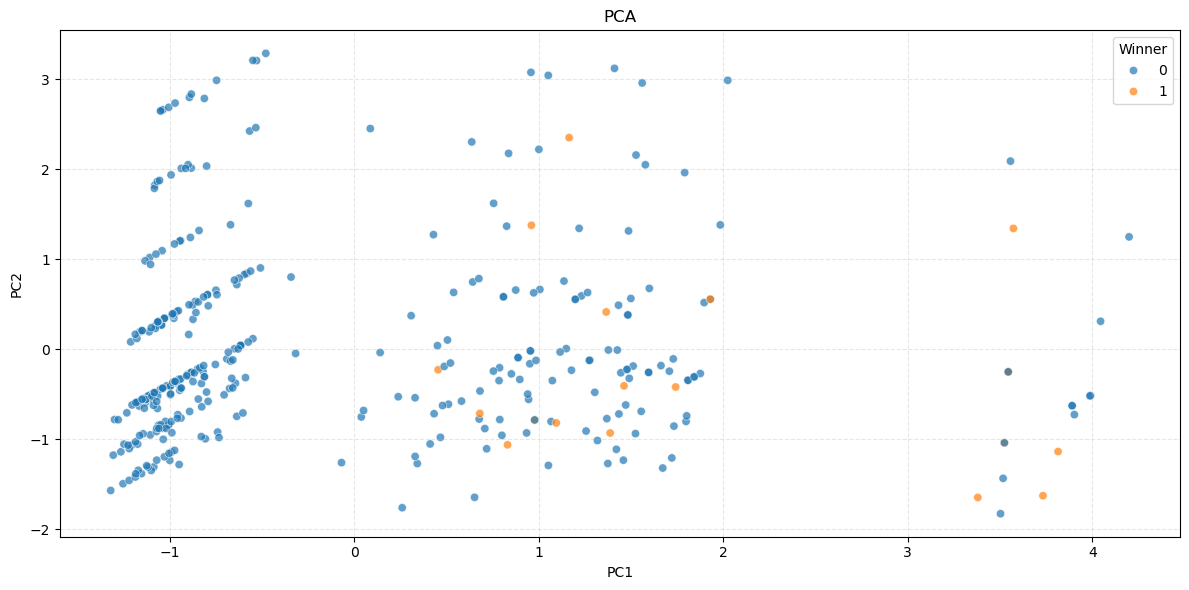

In [790]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df_components, x='PC1', y='PC2', hue='Winner', alpha=0.7)
plt.title('PCA')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


In [791]:
# varianza explicada por cada componente
explained_var = pca.explained_variance_ratio_
explained_var

array([0.31758804, 0.20525682, 0.17707692, 0.16002309, 0.05356629])

In [792]:
# varianza acumulada
cumulative_var = np.cumsum(explained_var)
cumulative_var

array([0.31758804, 0.52284486, 0.69992177, 0.85994486, 0.91351115])

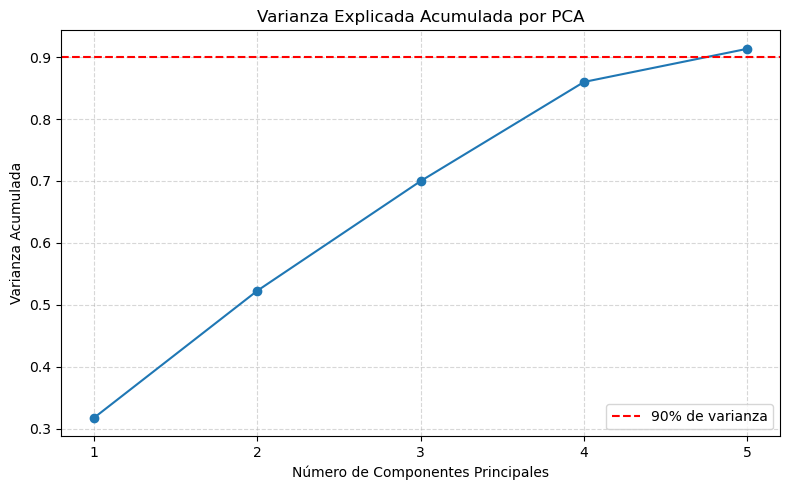

In [793]:
# Gráfico
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada')
plt.title('Varianza Explicada Acumulada por PCA')
plt.axhline(y=0.9, color='red', linestyle='--', label='90% de varianza')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks([1, 2, 3, 4, 5])
plt.legend()
plt.tight_layout()
plt.show()
